In [ ]:
%matplotlib inline
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# plt.style.use('dark_background')

from modules import ELBO
from utils import load_sim_data

### Setup parameters

In [2]:
N = 11
sim_curvature = 30 # simulated average curvature (in degrees)
out_dict = "/Users/nguyentiendung/GitHub/perceptual-straightening/model/"
data_path = "/Users/nguyentiendung/GitHub/perceptual-straightening/data/simulations/"

### Run inference

In [3]:
model = ELBO(N, data_path)

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_file = Path(out_dict) / f'model_{sim_curvature}.pt'

#### Pre-train optimizer by only optimizing KL-divergence first (find a good initialization)

In [4]:
iterations = 10000
kl_loss = np.zeros(iterations)

for i in range(iterations):
    kl = model.kl_divergence()
    kl.backward()
    optimizer.step()
    optimizer.zero_grad()

    kl_loss[i] = kl.item()

    if not i % 1000:
        print(f"Epoch: {i}, Loss: {kl.item()}")

Epoch: 0, Loss: 5925.703125
Epoch: 1000, Loss: 4599.74365234375
Epoch: 2000, Loss: 3643.25048828125
Epoch: 3000, Loss: 2910.039306640625
Epoch: 4000, Loss: 2328.764892578125
Epoch: 5000, Loss: 1860.19140625
Epoch: 6000, Loss: 1479.6544189453125
Epoch: 7000, Loss: 1170.0054931640625
Epoch: 8000, Loss: 918.3594970703125
Epoch: 9000, Loss: 714.5033569335938


/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


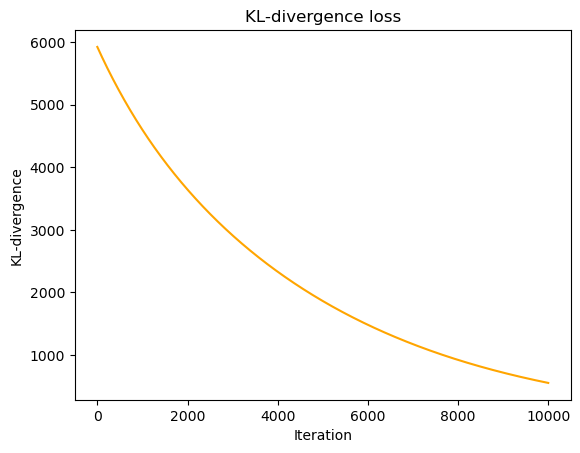

In [5]:
plt.plot(kl_loss, color='orange')
plt.title('KL-divergence loss')
plt.xlabel('Iteration')
plt.ylabel('KL-divergence')
plt.show()

#### Optimize the whole ELBO

In [ ]:
iterations = 5000
errors = np.zeros(iterations)
kl_loss = np.zeros(iterations)
ll_loss = np.zeros(iterations)

best_iteration = 0
for i in range(iterations):
    log_ll, d, c, a = model.compute_likelihood()
    kl = model.kl_divergence()
    loss = model.compute_loss(log_ll, kl)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    errors[i] = loss.item()
    kl_loss[i] = kl.item()
    ll_loss[i] = log_ll.item()

    # save best model but exclude the ones whose errors are below 0
    if errors[i] <= errors[best_iteration] and (not errors[i] < 0):
        d_best = d
        c_best = c
        a_best = a
        torch.save(model.state_dict(), model_file)
        best_iteration = i

    # print progress
    if not i % 100:
        print(f"Epoch: {i}, Loss: {loss.item()}")

    # stop when error becomes too negative
    if errors[i] < -300: 
        errors = errors[:i+1]
        kl_loss = kl_loss[:i+1]
        ll_loss = ll_loss[:i+1]
        break

print(f'Best epoch: {best_iteration}, Loss: {errors[best_iteration]}')

Epoch: 0, Loss: 1917.77783203125
Epoch: 100, Loss: 1916.3453369140625
Epoch: 200, Loss: 1486.72021484375
Epoch: 300, Loss: 1486.5611572265625
Epoch: 400, Loss: 1553.48291015625
Epoch: 500, Loss: 1371.004150390625
Epoch: 600, Loss: 1237.340576171875
Epoch: 700, Loss: 1362.1207275390625
Epoch: 800, Loss: 1216.035888671875
Epoch: 900, Loss: 1100.2818603515625
Epoch: 1000, Loss: 1009.6986694335938
Epoch: 1100, Loss: 1000.3404541015625
Epoch: 1200, Loss: 1164.431640625
Epoch: 1300, Loss: 830.7769775390625
Epoch: 1400, Loss: 954.407470703125
Epoch: 1500, Loss: 811.7171020507812
Epoch: 1600, Loss: 894.69482421875
Epoch: 1700, Loss: 871.61474609375
Epoch: 1800, Loss: 962.5631103515625
Epoch: 1900, Loss: 638.2980346679688
Epoch: 2000, Loss: 602.180908203125
Epoch: 2100, Loss: 598.5256958007812
Epoch: 2200, Loss: 547.9218139648438
Epoch: 2300, Loss: 722.4556884765625
Epoch: 2400, Loss: 382.99505615234375
Epoch: 2500, Loss: 509.18798828125
Epoch: 2600, Loss: 526.6841430664062
Epoch: 2700, Loss: 4

#### Load final model and plot error curves

In [ ]:
best_model = ELBO(N, data_path)
best_model.load_state_dict(torch.load(model_file))

In [ ]:
fig, ax1 = plt.subplots()

# Primary y-axis (ELBO and Neg. log likelihood)
ax1.plot(errors, label='ELBO')
ax1.plot(ll_loss, label='Log likelihood')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log likelihood')
ax1.tick_params(axis='y')

# Add title
plt.title('Loss over iterations')

# Create a secondary y-axis for KL loss
ax2 = ax1.twinx()
ax2.plot(kl_loss[:3800], label='KL', color='orange')
ax2.set_ylabel('KL Loss')
ax2.tick_params(axis='y')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# save and show the plot
plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
plt.show()

### Reconstruct trajectory

In [ ]:
est_global_curvature = best_model.mu_c.detach().numpy() * (180 / np.pi)
print(f'Estimated global curvature: {est_global_curvature[0]} degrees')
print(f'Average estimated local curvature: {torch.mean(c_best).detach().numpy() * (180/np.pi)} degrees')

In [ ]:
def run_pca(X, n_components=2):
    """
    Run PCA on the estimated trajectory. 

    Inputs:
    -------
    X: (n_dimensions x n_frames) torch tensor
        Input matrix (estimated trajectory)
    n_components: Scalar
        Number of fitted principle components

    Output:
    -------
    X_new: (n_frames x n_components) numpy array
        Transformed values
    """
    
    pca = PCA(n_components)
    pca.fit(X)
    return pca.components_

In [ ]:
# # load simulated data
# discrim_mat = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'discriminality_matrix.mat')['Pc_reshaped'])

# # plot data
# ax = sns.heatmap(discrim_mat, cmap='Blues')
# ax.invert_yaxis()
# plt.show()

In [ ]:
# run PCA to reduce the dimensionality of the trajectory
x = torch.squeeze(best_model.construct_trajectory(torch.mean(d_best, dim=0, keepdim=True), 
                               torch.mean(c_best, dim=0, keepdim=True), 
                               torch.mean(a_best, dim=0, keepdim=True)))

pc = run_pca(x.t().detach().numpy())
for i in range(pc.shape[1]-1):
    plt.plot([pc[0, i], pc[0, i+1]], [pc[1, i], pc[1, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in PC space')
plt.show()

In [ ]:
# visualize the perceptual trajectory for >= 3d (plotting first 3 dimensions)
x_np = x.detach().numpy().T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(pc.shape[1]-1):
    plt.plot([x_np[0, i], x_np[0, i+1]], 
             [x_np[1, i], x_np[1, i+1]],
             [x_np[2, i], x_np[2, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in 3D')
plt.show()

In [ ]:
# plot histograms of trajectory variables
fig, axs = plt.subplots()
sns.histplot(c_best.detach().numpy() * (180 / np.pi), kde=True, ax=axs)
axs.set_xlabel('Curvature (degrees)')
axs.set_title('Curvature distribution')
plt.show()

In [ ]:
best_model.A